In [1]:
import os
import intake
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# To use dask across the cluster
from dask_jobqueue import SLURMCluster
from dask.distributed import Client


from methods import (t_prime_calculation, 
                     dask_data_to_xarray,
                     area_calculation_real_area,
                     dists_of_lat_eff,
                     temp_ref)


import matplotlib
matplotlib.rcParams.update({'font.size': 15})

In [2]:
cluster = SLURMCluster(nanny=True)
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p broadwl
#SBATCH -n 1
#SBATCH --cpus-per-task=4
#SBATCH --mem=19G
#SBATCH -t 00:36:00
#SBATCH --qos=covid-19
#SBATCH --account=covid-19
#SBATCH --output=dask_worker.out
#SBATCH --error=dask_worker.err

/scratch/midway2/ivanhigueram/reanalysis_env/bin/python -m distributed.cli.dask_worker tcp://172.25.220.71:49010 --nthreads 4 --memory-limit 20.00GB --name name --nanny --death-timeout 60 --local-directory $SCRATCH --interface ib0



In [3]:
client = Client(cluster)

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33104")
client

Client Scheduler: tcp://127.0.0.1:33104 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 269.63 GB


In [4]:
cluster.scale(40)

In [3]:
client.upload_file('methods.py')

from methods import (t_prime_calculation, 
                         dask_data_to_xarray,
                         area_calculation_real_area,
                         dists_of_lat_eff,
                         temp_ref)



### Download CIMP6 Model Data

In [3]:
url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
col

,unique
activity_id,15
institution_id,33
source_id,73
experiment_id,103
member_id,141
table_id,29
variable_id,369
grid_label,10
zstore,269423
dcpp_init_year,60


In [4]:
col.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,AS-RCEC,TaiESM1,histSST,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/AerChemMIP/AS-RCEC/TaiESM1/histSST/...,NaN
1,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrbc,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
2,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrdust,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
3,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmroa,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
4,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrso4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN


In [5]:
cat = col.search(experiment_id='ssp585', 
          institution_id = "NCAR",
           source_id = "CESM2-WACCM",
            variable_id = 'tas'
          )

In [6]:
cat.keys()

['ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn',
 'ScenarioMIP.NCAR.CESM2-WACCM.ssp585.day.gn']

In [8]:
def drop_time_bounds(ds):
    if 'time_bounds' in ds.coords:
        ds = ds.drop('time_bounds')
    elif 'time_bnds' in ds.coords:
        ds = ds.drop('time_bnds')
    return ds


dset_dict = cat.to_dataset_dict(
    zarr_kwargs={"consolidated": True, 
                 "decode_times": True
                }
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [9]:
dset_dict

{'ScenarioMIP.NCAR.CESM2-WACCM.ssp585.day.gn': <xarray.Dataset>
 Dimensions:    (lat: 192, lon: 288, member_id: 1, nbnd: 2, time: 31391)
 Coordinates:
     time_bnds  (time, nbnd) object dask.array<chunksize=(15696, 2), meta=np.ndarray>
     lon_bnds   (lon, nbnd) float32 dask.array<chunksize=(288, 2), meta=np.ndarray>
     lat_bnds   (lat, nbnd) float32 dask.array<chunksize=(192, 2), meta=np.ndarray>
   * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
   * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
   * time       (time) object 2015-01-01 00:00:00 ... 2101-01-01 00:00:00
   * member_id  (member_id) <U8 'r1i1p1f1'
 Dimensions without coordinates: nbnd
 Data variables:
     tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 398, 192, 288), meta=np.ndarray>
 Attributes:
     Conventions:             CF-1.7 CMIP-6.2
     activity_id:             ScenarioMIP
     branch_method:           standard
     branch_tim

In [10]:
def preprocesser(ds,
                 freq='12H',
                 winter=True,
                 start_date=None,
                 end_date=None):

    """
    Pre-processing file mapped to all files pasaed to the reader-n-cutter
    function.

    This pre-processing function mainly takes care of the dates within the
    files. Ideally, the user will pass a date boundary so files can be
    subsetted in the time dimension (index).
    """

    ds = ds.sortby('time')

    if winter is True:
        
        try:
            years_in_array = pd.DatetimeIndex(ds.time.values).year.unique().sort_values()

        except TypeError:
            min_date, max_date = ds.time.values.min(), ds.time.values.max()
        
        if len(years_in_array) == 2:
            date_array = pd.date_range(f'{years_in_array[0]}-12-01',
                                      f'{years_in_array[1]}-03-01',
                                      freq=freq)
            ds_subset = ds.where(
                ds.time.isin(date_array), drop=True)

        else:
            raise ValueError(f'{years_in_array} are more than the desired years')

    else:
        date_array =  pd.daate_range(start_date, end_date, freq=freq)

        ds_subset = ds.where(
                ds.time.isin(date_array), drop=True)

    return ds_subset

In [11]:
entry = cat[list(dset_dict.keys())[0]]
ds = entry(zarr_kwargs={'consolidated': True, 'decode_times': True}).to_dask()
ds

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, member_id: 1, nbnd: 2, time: 31391)
Coordinates:
    time_bnds  (time, nbnd) object dask.array<chunksize=(15696, 2), meta=np.ndarray>
    lon_bnds   (lon, nbnd) float32 dask.array<chunksize=(288, 2), meta=np.ndarray>
    lat_bnds   (lat, nbnd) float32 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 2015-01-01 00:00:00 ... 2101-01-01 00:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: nbnd
Data variables:
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 398, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             ScenarioMIP
    branch_method:           standard
    branch_time_in_child:    735110.0
    branch_time_in_parent:   735110.0
    case_id:                 43
    cesm_casename:           b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM...
    contact:                 cesm_cmip6@ucar.edu
    creation_date:           2019-02-08T20:55:56Z
    data_specs_version:      01.00.29
    experiment:              update of RCP8.5 based on SSP5
    experiment_id:           ssp585
    external_variables:      areacella
    forcing_index:           1
    frequency:               day
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.NCAR.CESM2-...
    grid:                    native 0.9x1.25 finite volume grid (192x288 latx...
    grid_label:              gn
    initialization_index:    1
    institution:             National Center for Atmospheric Research, Climat...
    institution_id:          NCAR
    license:                 CMIP6 model data produced by <The National Cente...
    mip_era:                 CMIP6
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    nominal_resolution:      100 km
    parent_activity_id:      CMIP
    parent_experiment_id:    historical
    parent_mip_era:          CMIP6
    parent_source_id:        CESM2-WACCM
    parent_time_units:       days since 0001-01-01 00:00:00
    parent_variant_label:    r1i1p1f1
    physics_index:           1
    product:                 model-output
    realization_index:       1
    realm:                   atmos
    source:                  CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite ...
    source_id:               CESM2-WACCM
    source_type:             AOGCM BGC CHEM AER
    status:                  2020-02-06;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:          none
    sub_experiment_id:       none
    table_id:                day
    tracking_id:             hdl:21.14100/9221ca13-9cb6-4beb-840d-4f51ca7ec9a...
    variable_id:             tas
    variant_info:            CMIP6 CESM2 future scenario SSP5-8.5 between 201...
    variant_label:           r1i1p1f1
    intake_esm_varname:      tas
    intake_esm_dataset_key:  ScenarioMIP.NCAR.CESM2-WACCM.ssp585.day.gn

In [12]:
ds_cut = ds.sel(lat=slice(20, 90))
ds_cut_time = ds_cut.where(
     ds_cut.time.dt.season == 'DJF' , drop=True
)


In [13]:
ds_cut_time

<xarray.Dataset>
Dimensions:    (lat: 75, lon: 288, member_id: 1, nbnd: 2, time: 7741)
Coordinates:
    time_bnds  (time, nbnd) object dask.array<chunksize=(3871, 2), meta=np.ndarray>
    lon_bnds   (lon, nbnd) float32 dask.array<chunksize=(288, 2), meta=np.ndarray>
    lat_bnds   (lat, nbnd) float32 dask.array<chunksize=(75, 2), meta=np.ndarray>
  * lat        (lat) float64 20.26 21.2 22.15 23.09 ... 87.17 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 2015-01-01 00:00:00 ... 2101-01-01 00:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: nbnd
Data variables:
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 123, 75, 288), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             ScenarioMIP
    branch_method:           standard
    branch_time_in_child:    735110.0
    branch_time_in_parent:   735110.0
    case_id:                 43
    cesm_casename:           b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM...
    contact:                 cesm_cmip6@ucar.edu
    creation_date:           2019-02-08T20:55:56Z
    data_specs_version:      01.00.29
    experiment:              update of RCP8.5 based on SSP5
    experiment_id:           ssp585
    external_variables:      areacella
    forcing_index:           1
    frequency:               day
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.NCAR.CESM2-...
    grid:                    native 0.9x1.25 finite volume grid (192x288 latx...
    grid_label:              gn
    initialization_index:    1
    institution:             National Center for Atmospheric Research, Climat...
    institution_id:          NCAR
    license:                 CMIP6 model data produced by <The National Cente...
    mip_era:                 CMIP6
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    nominal_resolution:      100 km
    parent_activity_id:      CMIP
    parent_experiment_id:    historical
    parent_mip_era:          CMIP6
    parent_source_id:        CESM2-WACCM
    parent_time_units:       days since 0001-01-01 00:00:00
    parent_variant_label:    r1i1p1f1
    physics_index:           1
    product:                 model-output
    realization_index:       1
    realm:                   atmos
    source:                  CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite ...
    source_id:               CESM2-WACCM
    source_type:             AOGCM BGC CHEM AER
    status:                  2020-02-06;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:          none
    sub_experiment_id:       none
    table_id:                day
    tracking_id:             hdl:21.14100/9221ca13-9cb6-4beb-840d-4f51ca7ec9a...
    variable_id:             tas
    variant_info:            CMIP6 CESM2 future scenario SSP5-8.5 between 201...
    variant_label:           r1i1p1f1
    intake_esm_varname:      tas
    intake_esm_dataset_key:  ScenarioMIP.NCAR.CESM2-WACCM.ssp585.day.gn

In [ ]:
ds = ds_cut_time.compute()

In [ ]:
import cartopy.crs as ccrs
fig = plt.subplots(figsize=(15, 10))
ax = plt.axes(projection=ccrs.Orthographic(20,90))
ds.isel(member_id=0, time=-1).tas.plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_global(); ax.coastlines();

In [16]:
ds_cut_time.to_netcdf('/project2/geos39650/jet_stream/data/ScenarioMIP_NCAR_CESM2-WACCM_ssp585_day.nc4',
             mode = 'w', format = 'NETCDF4' )

### Using saved subset model

In [9]:
ds_cut_time = xr.open_dataset('/project2/geos39650/jet_stream/data/ScenarioMIP_NCAR_CESM2-WACCM_ssp585_day.nc4',
                              chunks={'time': 1})

ds_cut_time_member = ds_cut_time.isel(member_id=0, nbnd=0)
ds_cut_time_member

,Array,Chunk
Bytes,61.93 kB,8 B
Shape,"(7741,)","(1,)"
Count,15483 Tasks,7741 Chunks
Type,object,numpy.ndarray


In [1]:
import time
from datetime import datetime
from dateutil.relativedelta import relativedelta

for year in range(2015, 2101, 10):
    # Define time ranges 
    start_year = datetime(year, 12, 1).strftime('%Y-%m-%d')
    end_year = datetime(year + 10, 3, 1).strftime('%Y-%m-%d')
    
    print(f'Processing: {start_year} to {end_year}')
    # Set up infrastructure
    cluster = SLURMCluster(nanny=False)
    print(cluster.job_script())
    
    client = Client(cluster)
    cluster.scale(30)
    
    # Wait for clients
    time.sleep(60)
    print(client)
    
    # Open file and slice to the desired time range
    print(f'Open File and start processing')
    xarray_list_daily = xr.open_dataset('/project2/geos39650/jet_stream/data/ScenarioMIP_NCAR_CESM2-WACCM_ssp585_day.nc4',
                              chunks={'time': 1})

    xarray_list_daily = xarray_list_daily.isel(member_id=0, nbnd=0)
    
    datetime_index = xarray_list_daily.indexes['time'].to_datetimeindex()
    xarray_list_daily['time'] = datetime_index
    
    xarray_list_daily = xarray_list_daily.sel(time=slice(start_year, end_year))
    
    # To dask dataframe
    t_df = xarray_list_daily.to_dask_dataframe(dim_order=['time', 'lat', 'lon'])

    t_df_renamed = t_df.rename(columns={
        'lat': 'latitude',
        'lon': 'longitude',
        'tas': 't2m'
    })
    t_df_filtered = t_df_renamed[['time', 'latitude', 'longitude', 't2m']]    
    
    # Calculate t-prime for the desired time range
    print(f'Start t-prime calulation')
    test_ultimate = t_prime_calculation(t_df_filtered,
                                        resample_time=False,
                                        grouping_time_interval='1w',
                                        build_buckets=True,
                                        cut_interval=2,
                                        grid_lat=0.9,
                                        grid_lon=1.25
                                       )
    
    # Save results to NetCDF
    print(f'Saving file to netcdf')
    print(test_ultimate.head())
    t_ref_test = dask_data_to_xarray(df=test_ultimate,
                             dims=['time', 'latitude', 'longitude'],
                             target_variable='tref')
    
    t_ref_test.to_netcdf(f'/project2/geos39650/jet_stream/data/t_ref_no_resample_cimp6_{start_year}_{end_year}.nc4')
    
    # Close connections and free resources
    client.close()
    cluster.close()

Processing: 2015-12-01 to 2025-03-01


NameError: name 'SLURMCluster' is not defined

In [ ]:
client.close()
cluster.close()

In [36]:
import xarray as xr
path = '/project2/geos39650/jet_stream/data/model_output/t_ref_gcm_2065-12-01_2075-03-01.nc4'

array_text = xr.open_dataset(path)

In [37]:
array_text

<xarray.Dataset>
Dimensions:                        (latitude: 75, longitude: 288, time: 900)
Coordinates:
  * time                           (time) datetime64[ns] 2065-12-01 ... 2075-02-28
  * latitude                       (latitude) float64 20.26 21.2 ... 89.06 90.0
  * longitude                      (longitude) float64 0.0 1.25 ... 357.5 358.8
Data variables:
    __xarray_dataarray_variable__  (time, latitude, longitude) float64 ...

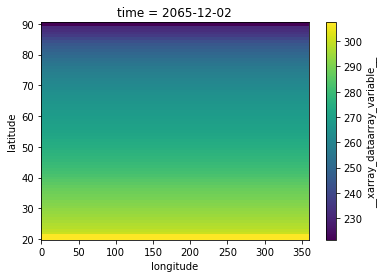

In [38]:
array_text.__xarray_dataarray_variable__.isel(time=1).plot()

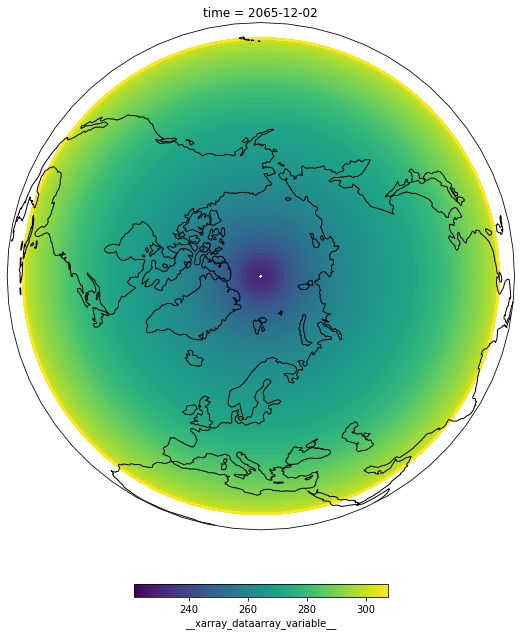

In [39]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


fig_ = plt.figure(figsize=(20, 20))
ax_1 = fig_.add_subplot(121, projection=ccrs.Orthographic(20, 90))

array_text.__xarray_dataarray_variable__.isel(time=1).plot.pcolormesh(ax=ax_1,
                                      #cmap='RdBu_r',
                                      #vmax=-50,
                                      #vmin=50,
                                      #center=0,
                                      transform=ccrs.PlateCarree(),
                                      extend='neither',
                                      cbar_kwargs={'orientation': 'horizontal',
                                                  'pad': 0.05,
                                                  'shrink': 0.5,
                                                  'spacing': 'proportional'
                                                 }
                         )


ax_1.set_global()
ax_1.coastlines()

In [34]:
import dask.dataframe as dd
import pandas as pd

In [35]:
import numpy as np

In [ ]:
np.

In [ ]:
df_test = {
    'lat':,
    'lon':,
    'value'
}